# Plot Mechanical Stress at several C-rates

In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)

eSOH_DIR = "../data/esoh/"
oCV_DIR = "../data/ocv/"
cyc_DIR = "../data/cycling/"
fig_DIR = "../figures/figures_model/"
res_DIR = "../data/results_model/"
%matplotlib widget

In [2]:
parameter_values = get_parameter_values()

In [3]:
spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        "loss of active material": "stress-driven",
        "lithium plating": "irreversible",
        "stress-induced diffusion": "false",
    }
)
# spm.print_parameter_info()
param=spm.param

In [4]:
cell = 10
sno = 15
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
print(Temp)

25


In [5]:
par_val = {}
# Previous i.e. tuning mech sim sep and then Li plating
par_val[0] = [1.2715e-07,1.2727e-06,1.1992,1.353e-9,0,0]
# Using only C/5 and 1.5C Cycling aging, cost function with Cn,Cp,x100,y0
par_val[1] = [1.4819e-07,1.5114e-06,1.2484,1.4732e-09,0,0]
# Using only C/5 and 1.5C Cycling aging, cost function with Cn,Cp,C,LLI(%)
par_val[2] = [1.4493e-07,1.3608e-06,1.199,1.2138e-09,0,0]
# Using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging, cost function with Cn,Cp,x100,y0
par_val[3] = [1.043e-07,1.036e-06,1.208,1.6045e-09,0,0]
# Using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging, cost function with Cn,Cp,C,LLI(%)
par_val[4] = [8.755e-08,8.572e-07,1.135,1.5788e-09,0,0]
# Using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging, cost function with Cn,Cp,C,LLI(%) another initial condition
par_val[5] = [8.7698e-08,8.5848e-07,1.1354,1.5778e-09,0,0]
# New Mech Damage Model
par_val[6] = [2.056E-07,2.4664E-06,1.2468,1.0482e-09,0,0]
# New Mech Damage Model with Lithium plating resistane
par_val[7] = [2.190e-07,2.308e-06,1.214,2.537e-09,0]
# New Assymetric Mech Damage Model, tuned using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging
par_val[8] = [1.426e-07,3.832e-06,1.215,2.35e-09,1.462e-06,0]
# New Assymetric Mech Damage Model, tuned using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging version 2
par_val[9] = [1.41036e-07,2.3913188000000003e-06,1.2098,2.4487124e-09,7.330208e-08,0]
# New Assymetric Mech Damage Model, tuned using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging version 3
par_val[10] = [1.414e-07,1.5045e-06,1.2094,2.45e-09,4.603e-08,0]
# Post processing LAM model using simulated stress, tuned using C/5 and 1.5C Cycling aging 
par_val[11] = [4.2298e-08,3.1590e-07,1.0773,2.3688e-09,1.8939e-08,0]
# Post processing LAM model using simulated stress, tuned using C/5 and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging 
par_val[12] = [8.4600e-09,2.8926e-07,1.0462,2.8351e-09,7.6933e-11,0]
# Post processing LAM model using simulated stress, tuned using C/5 and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging version 2
par_val[13] = [4.0689e-08,2.8887e-07,1.0484,2.4848e-09,7.6548e-12,5.8577e-11]
# Post processing LAM model using simulated stress, tuned using C/5 and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging negative beta
par_val[14] = [4.0419e-08,2.8956e-07,1.0788,2.3578e-09,-7.8991e-09,-1.4254e-09]
# Post processing LAM model using simulated stress, tuned using C/5 and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging V1: correct Omega
par_val[15] = [4.0312e-08,1.8157e-07,1.0776,2.3586e-09,-4.9170e-09,-1.4406e-09]
# Post processing LAM model using simulated stress, tuned using C/5 and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging V2: New critical stress values
par_val[16] = [3.7270e-09,5.4495e-08,1.0593,3.1062e-09,-1.4317e-09,-1.5005e-10]
# par_val[16] = [5.9604e-08,3.7083e-07,1.1885,2.1512e-09,-9.0250e-09,-8.5400e-11]
# par_val[15] = [1.8738e-07,3.5218e-07,1.0998,2.5332e-09,7.6933e-13,7.6933e-13]
par_val[17]= [3.9120e-08,1.7582e-07,1.0612,1.4662e-11,-4.2190e-09,-1.7768e-09]

par_val[18]= [4.0260e-08,1.7690e-07,1.0613,1.4276e-11,-3.9503e-09,-1.7136e-09]

In [6]:
parameter_values = get_parameter_values()
parameter_values.update(
    {
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        "Initial temperature [K]": 273.15+Temp,
        "Ambient temperature [K]": 273.15+Temp,
        "Positive electrode LAM constant proportional term [s-1]": par_val[sno][0],
        "Negative electrode LAM constant proportional term [s-1]": par_val[sno][1],
        "Positive electrode LAM constant proportional term 2 [s-1]": par_val[sno][5],
        "Negative electrode LAM constant proportional term 2 [s-1]": par_val[sno][4],
        "Positive electrode LAM constant exponential term": par_val[sno][2],
        "Negative electrode LAM constant exponential term": par_val[sno][2],
        "SEI kinetic rate constant [m.s-1]":  4.60788219e-16, #1.08494281e-16 , 
        "EC diffusivity [m2.s-1]": 4.56607447e-19,#8.30909086e-19,
        "SEI growth activation energy [J.mol-1]": 1.87422275e+04,#1.58777981e+04,
        "Lithium plating kinetic rate constant [m.s-1]": par_val[sno][3],
        "Initial inner SEI thickness [m]": 0e-09,
        "Initial outer SEI thickness [m]": 5e-09,
        "SEI resistivity [Ohm.m]": 30000.0,
        "Negative electrode partial molar volume [m3.mol-1]": 7e-06,
        "Negative electrode LAM min stress [Pa]": 0,
        "Negative electrode LAM max stress [Pa]": 0,
        "Positive electrode LAM min stress [Pa]": 0,
        "Positive electrode LAM max stress [Pa]": 0,
        # "Negative electrode critical stress [Pa]": 20e+06,
        # "Positive electrode critical stress [Pa]": 40e+06,
    },
    check_already_exists=False,
)

In [7]:
# c_rate_d = '2C'
# c_rate_c = '1.5C'
c_rate_c ='C/5'
c_rate_d ='C/5'

In [8]:
# pybamm.set_logging_level("WARNING")
pybamm.set_logging_level("NOTICE")
experiment = pybamm.Experiment(
    [
        (
        #  "Rest for 10 minutes", 
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50",
        #  "Rest for 20 minutes",
         )
    ],
    termination="50% capacity",
    period = "10 sec",
#     cccv_handling="ode",
)

experiment = pybamm.Experiment(
    [
        (
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50",
         "Rest for 5 min",
         "Discharge at "+c_rate_d+" until 3V",
        #  "Discharge at "+c_rate_d+" for 150 min",
         )
    ],
    termination="50% capacity",
    period = "10 sec",
#     cccv_handling="ode",
)
SOC_0 = 0.5
parameter_values.update(
    {
        "Negative electrode LAM min stress [Pa]": -4947907,
        "Negative electrode LAM max stress [Pa]": 4948199,
        "Positive electrode LAM min stress [Pa]": 0,
        "Positive electrode LAM max stress [Pa]": 0,
    },
    check_already_exists=False,
)

In [9]:
sim_long = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_long = sim_long.solve(initial_soc=SOC_0)
solution1 = sol_long

2023-08-25 07:56:00.699 - [NOTICE] callbacks.on_cycle_start(174): Cycle 1/1 (15.657 ms elapsed) --------------------
2023-08-25 07:56:00.701 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 1/4: Charge at C/5 until 4.2V
2023-08-25 07:56:00.822 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 2/4: Hold at 4.2V until C/50
2023-08-25 07:56:00.945 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 3/4: Rest for 5 min
2023-08-25 07:56:00.988 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 4/4: Discharge at C/5 until 3V
2023-08-25 07:56:01.533 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.796 Ah (originally 4.796 Ah, will stop at 2.398 Ah)
2023-08-25 07:56:01.534 - [NOTICE] callbacks.on_experiment_end(222): Finish experiment simulation, took 848.400 ms


In [10]:
# parameter_values.update(
#     {
#     #   "Exchange-current density for plating [A.m-2]":0.001,
#     #   "Lithium plating transfer coefficient": 0.5,
#     #   "Dead lithium decay constant [s-1]": 1E-4,
#         # "Exchange-current density for stripping [A.m-2]": 0.00005,
#     },
#     check_already_exists=False,
# )
c_rate_c ='C/5'
c_rate_c ='1.5C'
c_rate_d ='1.5C'
# c_rate_c ='2C'
experiment = pybamm.Experiment(
    [
        (
        #  "Rest for 10 minutes",
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50",
        #  "Rest for 20 minutes",
         )
    ],
    termination="50% capacity",
    period = "1 sec",
#     cccv_handling="ode",
)
experiment = pybamm.Experiment(
    [
        (
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50",
         "Rest for 5 min",
         "Discharge at "+c_rate_d+" until 3V",
         )
    ],
    termination="50% capacity",
    period = "1 sec",
#     cccv_handling="ode",
)
drive_cycle = pd.read_csv(cyc_DIR+'peyman_drive_cycle_current'+'.csv', comment="#", header=None).to_numpy()
# experiment = pybamm.Experiment(
#     [
#         (
#          "Charge at "+c_rate_c+" until 4.2V", 
#          "Hold at 4.2V until C/50",
#          "Rest for 5 min",
#          "Run DriveCycle (A)",
#         )
#     ] ,
#     drive_cycles={"DriveCycle": drive_cycle},
#     termination="50% capacity",
# #     cccv_handling="ode",
# )
SOC_0 = 0.5
parameter_values.update(
    {
        "Negative electrode LAM min stress [Pa]": -37947482,
        "Negative electrode LAM max stress [Pa]": 37960494,
        "Positive electrode LAM min stress [Pa]": 0,
        "Positive electrode LAM max stress [Pa]": 0,
    },
    check_already_exists=False,
)

sim_long = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_long = sim_long.solve(initial_soc=SOC_0)
solution2 = sol_long

FileNotFoundError: [Errno 2] No such file or directory: '../data/cycling/peyman_drive_cycle_current.csv'

In [ ]:
# parameter_values.update(
#     {
#     #   "Exchange-current density for plating [A.m-2]":0.001,
#     #   "Lithium plating transfer coefficient": 0.5,
#     #   "Dead lithium decay constant [s-1]": 1E-4,
#         # "Exchange-current density for stripping [A.m-2]": 0.00005,
#     },
#     check_already_exists=False,
# )
# parameter_values.update(
#     {
#         "Negative electrode LAM constant proportional term 2 [s-1]": 7.5*par_val[sno][4],

#     },
#     check_already_exists=False,
# ) 
c_rate_c ='C/5'
# c_rate_c ='1.5C'
c_rate_d ='1.5C'
# c_rate_c ='2C'
experiment = pybamm.Experiment(
    [
        (
        #  "Rest for 10 minutes",
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50",
        #  "Rest for 20 minutes",
         )
    ],
    termination="50% capacity",
    period = "1 sec",
#     cccv_handling="ode",
)
experiment = pybamm.Experiment(
    [
        (
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50",
         "Rest for 5 min",
         "Discharge at "+c_rate_d+" until 3V",
         )
    ],
    termination="50% capacity",
    period = "1 sec",
#     cccv_handling="ode",
)
drive_cycle = pd.read_csv(cyc_DIR+'peyman_drive_cycle_current'+'.csv', comment="#", header=None).to_numpy()
# experiment = pybamm.Experiment(
#     [
#         (
#          "Charge at "+c_rate_c+" until 4.2V", 
#          "Hold at 4.2V until C/50",
#          "Rest for 5 min",
#          "Run DriveCycle (A)",
#         )
#     ] ,
#     drive_cycles={"DriveCycle": drive_cycle},
#     termination="50% capacity",
# #     cccv_handling="ode",
# )
SOC_0 = 0.5

parameter_values.update(
    {
        "Negative electrode LAM min stress [Pa]": -5083876,
        "Negative electrode LAM max stress [Pa]": 38131043,
        "Positive electrode LAM min stress [Pa]": 0,
        "Positive electrode LAM max stress [Pa]": 0,
    },
    check_already_exists=False,
)



sim_long = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_long = sim_long.solve(initial_soc=SOC_0)
solution3 = sol_long

2023-06-13 10:32:28.518 - [NOTICE] callbacks.on_cycle_start(174): Cycle 1/1 (14.952 ms elapsed) --------------------
2023-06-13 10:32:28.519 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 1/4: Charge at C/5 until 4.2V
2023-06-13 10:32:28.707 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 2/4: Hold at 4.2V until C/50
2023-06-13 10:32:28.893 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 3/4: Rest for 5 min
2023-06-13 10:32:28.936 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 4/4: Discharge at 1.5C until 3V
2023-06-13 10:32:29.925 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.797 Ah (originally 4.797 Ah, will stop at 2.398 Ah)
2023-06-13 10:32:29.926 - [NOTICE] callbacks.on_experiment_end(222): Finish experiment simulation, took 1.421 s


In [ ]:
c_rate_c = '1.5C'
drive_cycle = pd.read_csv(cyc_DIR+'peyman_drive_cycle_current'+'.csv', comment="#", header=None).to_numpy()
experiment = pybamm.Experiment(
    [
        (
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50",
         "Rest for 5 min",
         "Run DriveCycle (A)",
        )
    ] ,
    drive_cycles={"DriveCycle": drive_cycle},
    termination="50% capacity",
#     cccv_handling="ode",
)
SOC_0 = 0 

parameter_values.update(
    {
        "Negative electrode LAM min stress [Pa]": -28221466,
        "Negative electrode LAM max stress [Pa]":  17687100,
        "Positive electrode LAM min stress [Pa]": 0,
        "Positive electrode LAM max stress [Pa]": 0,
    },
    check_already_exists=False,
)

sim_long = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_long = sim_long.solve(initial_soc=SOC_0)
solution4 = sol_long

2023-06-13 10:32:31.496 - [NOTICE] callbacks.on_cycle_start(174): Cycle 1/1 (13.939 ms elapsed) --------------------
2023-06-13 10:32:31.497 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 1/4: Charge at 1.5C until 4.2V
2023-06-13 10:32:31.587 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 2/4: Hold at 4.2V until C/50
2023-06-13 10:32:31.697 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 3/4: Rest for 5 min
2023-06-13 10:32:31.808 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 4/4: Run DriveCycle (A)
2023-06-13 10:32:33.066 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.792 Ah (originally 4.792 Ah, will stop at 2.396 Ah)
2023-06-13 10:32:33.066 - [NOTICE] callbacks.on_experiment_end(222): Finish experiment simulation, took 1.583 s


In [ ]:
def plot_vars(solution):
    t =  solution["Time [s]"].entries
    t = t/3600
    V =  solution["Terminal voltage [V]"].entries
    I =  solution["Current [A]"].entries
    Q = -solution['Discharge capacity [A.h]'].entries
    Q_Li = solution["Loss of capacity to lithium plating [A.h]"].entries
    I_Li = solution["X-averaged lithium plating interfacial current density [A.m-2]"].entries

    I_de = solution["X-averaged negative electrode interfacial current density [A.m-2]"].entries
    I_st = solution["X-averaged lithium plating interfacial current density"].entries
    I_to = solution["X-averaged negative electrode total interfacial current density [A.m-2]"].entries

    # phi_seif = solution["X-averaged SEI film overpotential [V]"].entries
    phi_seif = []
    # phi_sei  = solution["X-averaged negative electrode sei reaction overpotential [V]"].entries
    phi_sei  = []
    # phi_sei = 0
    phi_pl  = solution["X-averaged negative electrode lithium plating reaction overpotential [V]"].entries
    phi_pl_nd  = solution["X-averaged negative electrode lithium plating reaction overpotential"].entries
    phi_del = solution["X-averaged negative electrode surface potential difference [V]"].entries

    phi_ocp = solution["X-averaged negative electrode open circuit potential [V]"].entries
    phi_int = solution["X-averaged negative electrode reaction overpotential [V]"].entries

    i0_int = solution["X-averaged negative electrode exchange current density [A.m-2]"].entries
    phi_e_avg = solution["X-averaged negative electrolyte potential [V]"].entries
    c_e_avg = solution["X-averaged negative electrolyte concentration [mol.m-3]"].entries
    c_ss_n = solution["X-averaged negative particle surface concentration"].entries
    c_save_n1 = solution["R-averaged negative particle concentration"].entries
    c_save_n = c_save_n1[1,:]
    c_s_n = solution["X-averaged negative particle concentration"].entries

    u_css_n = solution["X-averaged negative electrode open circuit potential [V]"].entries

    # j_pl = solution["Negative electrode lithium plating interfacial current density [A.m-2]"].entries
    j_pl = []
    # eta_pl = solution["Negative electrode lithium plating reaction overpotential [V]"].entries
    eta_pl = []
    sigma_ts_n = solution["X-averaged negative particle surface tangential stress [Pa]"].entries
    sigma_rs_n = solution["X-averaged negative particle surface radial stress [Pa]"].entries
    sigma_hs_n = (sigma_rs_n+2*sigma_ts_n)/2
    sigma_ts_p = solution["X-averaged positive particle surface tangential stress [Pa]"].entries
    sigma_rs_p = solution["X-averaged positive particle surface radial stress [Pa]"].entries
    sigma_hs_p = (sigma_rs_p+2*sigma_ts_p)/2
    # sigma_ts_n = []
    # sigma_rs_n = []
    # sigma_hs_n = []
    # sigma_ts_p = []
    # sigma_rs_p = []
    # sigma_hs_p = []

    C_n = solution["Negative electrode capacity [A.h]"].entries
    C_p = solution["Positive electrode capacity [A.h]"].entries

    return t,V,I,Q,Q_Li,I_Li,I_de,I_st,I_to,phi_seif,phi_sei,phi_pl,phi_del,phi_ocp,phi_int,i0_int,phi_e_avg,c_e_avg,c_ss_n,c_save_n,c_s_n,u_css_n,j_pl,eta_pl,sigma_hs_n,C_n,sigma_hs_p,C_p

# Compare Stress, Plating C Rates

In [ ]:
t1,V1,I1,Q1,Q_Li1,I_Li1,I_de1,I_st1,I_to1,phi_seif1,phi_sei1,phi_pl1,phi_del1,phi_ocp1,phi_int1,i0_int1,phi_e_avg1,c_e_avg1,c_ss_n1,c_save_n1,c_s_n1,u_css_n1,j_pl1,eta_pl1,sigma_hs_n1,C_n1,sigma_hs_p1,C_p1 = plot_vars(solution1)
t2,V2,I2,Q2,Q_Li2,I_Li2,I_de2,I_st2,I_to2,phi_seif2,phi_sei2,phi_pl2,phi_del2,phi_ocp2,phi_int2,i0_int2,phi_e_avg2,c_e_avg2,c_ss_n2,c_save_n2,c_s_n2,u_css_n2,j_pl2,eta_pl2,sigma_hs_n2,C_n2,sigma_hs_p2,C_p2 = plot_vars(solution2)
t3,V3,I3,Q3,Q_Li3,I_Li3,I_de3,I_st3,I_to3,phi_seif3,phi_sei3,phi_pl3,phi_del3,phi_ocp3,phi_int3,i0_int3,phi_e_avg3,c_e_avg3,c_ss_n3,c_save_n3,c_s_n3,u_css_n3,j_pl3,eta_pl3,sigma_hs_n3,C_n3,sigma_hs_p3,C_p3 = plot_vars(solution3)

In [ ]:
t4,V4,I4,Q4,Q_Li4,I_Li4,I_de4,I_st4,I_to4,phi_seif4,phi_sei4,phi_pl4,phi_del4,phi_ocp4,phi_int4,i0_int4,phi_e_avg4,c_e_avg4,c_ss_n4,c_save_n4,c_s_n4,u_css_n4,j_pl4,eta_pl4,sigma_hs_n4,C_n4,sigma_hs_p4,C_p4 = plot_vars(solution4)

In [ ]:
print(min(sigma_hs_n1))
print(max(sigma_hs_n1))
print(min(sigma_hs_n2))
print(max(sigma_hs_n2))
print(min(sigma_hs_n3))
print(max(sigma_hs_n3))

-5083014.720804467
5087671.38209612
-38111218.66825918
38165104.90579485
-5083201.504023985
38144848.34977405


In [ ]:
beta_LAM_n = param.n.beta_LAM_dimensional
beta_LAM2_n = param.n.beta_LAM_dimensional2
m_LAM_n = param.n.m_LAM
stress_critical_n = param.n.stress_critical_dim
j_stress_LAM_n1 = parameter_values.evaluate(-beta_LAM_n*(abs(min(sigma_hs_n1)) / stress_critical_n) ** m_LAM_n + 1*beta_LAM2_n*(abs(max(sigma_hs_n1)) / stress_critical_n) ** m_LAM_n)
j_stress_LAM_n2 = parameter_values.evaluate(-beta_LAM_n*(abs(min(sigma_hs_n2)) / stress_critical_n) ** m_LAM_n + 1*beta_LAM2_n*(abs(max(sigma_hs_n2)) / stress_critical_n) ** m_LAM_n)
j_stress_LAM_n3 = parameter_values.evaluate(-beta_LAM_n*(abs(min(sigma_hs_n3)) / stress_critical_n) ** m_LAM_n + 1*beta_LAM2_n*(abs(max(sigma_hs_n3)) / stress_critical_n) ** m_LAM_n)

In [ ]:
beta1= 1.8157e-07
beta2= -4.917e-09

In [ ]:
beta1/beta2

-36.9269880008135

In [ ]:
print(parameter_values.evaluate(beta_LAM_n))
print(parameter_values.evaluate(beta_LAM2_n))

1.8157e-07
-4.917e-09


In [ ]:
parameter_values.evaluate(beta_LAM_n)/parameter_values.evaluate(beta_LAM2_n)

-36.9269880008135

In [ ]:
parameter_values.evaluate(-beta_LAM_n*(abs(min(sigma_hs_n1)) / stress_critical_n) ** m_LAM_n)/ parameter_values.evaluate(beta_LAM2_n*(abs(max(sigma_hs_n1)) / stress_critical_n) ** m_LAM_n)

36.89056785851011

In [ ]:
parameter_values.evaluate(-beta_LAM_n*(abs(min(sigma_hs_n2)) / stress_critical_n) ** m_LAM_n)/ parameter_values.evaluate(beta_LAM2_n*(abs(max(sigma_hs_n2)) / stress_critical_n) ** m_LAM_n)

36.870807052466816

In [ ]:
parameter_values.evaluate(-beta_LAM_n*(abs(min(sigma_hs_n3)) / stress_critical_n) ** m_LAM_n)/ parameter_values.evaluate(beta_LAM2_n*(abs(max(sigma_hs_n3)) / stress_critical_n) ** m_LAM_n)

4.208449787864046

In [ ]:
# j_stress_LAM_n1 = -1.2671327275496018e-08
# j_stress_LAM_n2 = -1.1382681231454379e-07
# j_stress_LAM_n3 = -1.571975948605771e-08

In [ ]:
print(j_stress_LAM_n1)
print(j_stress_LAM_n2)
print(j_stress_LAM_n3)

-1.3044891323028042e-08
-1.1435963459486492e-07
-1.5719119678014853e-08


In [ ]:
act_n_loss1 = j_stress_LAM_n1*t1[-1]*3600
act_n_loss2 = j_stress_LAM_n2*t2[-1]*3600
act_n_loss3 = j_stress_LAM_n3*t3[-1]*3600

In [ ]:
print(act_n_loss1)
print(act_n_loss2)
print(act_n_loss3)

-0.0003440298441608439
-0.0005092148307306536
-0.00017996762262800005


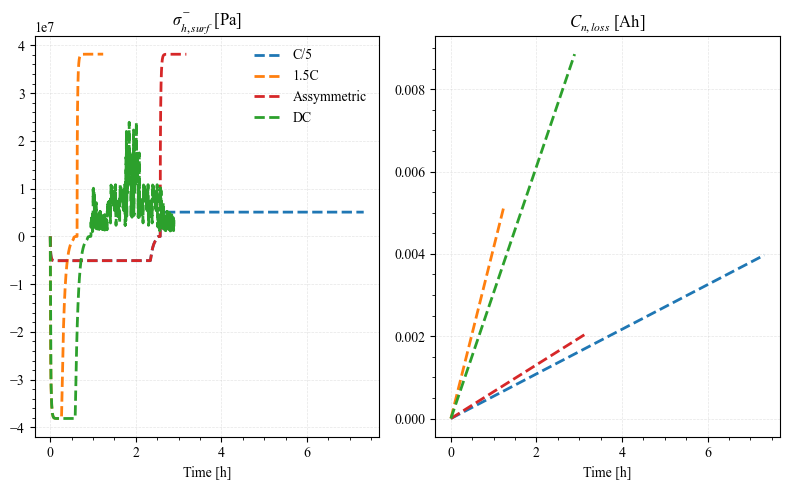

In [ ]:
# sigma_hs_n1_min = min(sigma_hs_n1/1e6)
# sigma_hs_n2_min = min(sigma_hs_n2/1e6)
# print(sigma_hs_n2_min/sigma_hs_n1_min)
# print(max(C_n2[0]-C_n2)/max(C_n1[0]-C_n1))
fig, ax = plt.subplots(1, 2, figsize=(8, 5))
ax1 = ax.flat[0]
ax1.plot(t1,sigma_hs_n1,'--',color='tab:blue')
ax1.plot(t2,sigma_hs_n2,'--',color='tab:orange')
ax1.plot(t3,sigma_hs_n3,'--',color='tab:red')
ax1.plot(t4,sigma_hs_n4,'--',color='tab:green')
ax1.set_title(r'$\sigma^-_{h,surf}$ [Pa]')
ax1.set_xlabel('Time [h]')
ax2 = ax.flat[1]
ax2.plot(t1,C_n1[0]-C_n1,'--',color='tab:blue')
ax2.plot(t2,C_n2[0]-C_n2,'--',color='tab:orange')
ax2.plot(t3,C_n3[0]-C_n3,'--',color='tab:red')
ax2.plot(t4,C_n4[0]-C_n4,'--',color='tab:green')
ax2.set_title(r'$C_{n,loss}$ [Ah]')
ax2.set_xlabel('Time [h]')
ax1.legend(["C/5","1.5C","Assymmetric","DC"])
# ax1.legend(["C/5","1.5C","Mixed"])
fig.tight_layout()
plt.show()
# plt.savefig(fig_DIR+'negative_electrode_stress'+'.png')
# plt.savefig(fig_DIR+'negative_electrode_stress_mixed'+'.png')

In [19]:
def graphite_volume_change_rate_mohtat(sto,c_s_max):
    stoichpoints = np.array([0,0.12,0.18,0.24,0.50,1])
    thicknesspoints = np.array([0,2.406/100,3.3568/100,4.3668/100,5.583/100,13.0635/100])
    i = 0
    if sto>=stoichpoints[i] and sto<stoichpoints[i+1]:
        t_change = (thicknesspoints[i+1]-thicknesspoints[i])/(stoichpoints[i+1]-stoichpoints[i])
    i = 1
    if sto>=stoichpoints[i] and sto<stoichpoints[i+1]:
        t_change = (thicknesspoints[i+1]-thicknesspoints[i])/(stoichpoints[i+1]-stoichpoints[i])
    i = 2
    if sto>=stoichpoints[i] and sto<stoichpoints[i+1]:
        t_change = (thicknesspoints[i+1]-thicknesspoints[i])/(stoichpoints[i+1]-stoichpoints[i])
    i = 3
    if sto>=stoichpoints[i] and sto<stoichpoints[i+1]:
        t_change = (thicknesspoints[i+1]-thicknesspoints[i])/(stoichpoints[i+1]-stoichpoints[i])
    i = 4
    if sto>=stoichpoints[i] and sto<=stoichpoints[i+1]:
        t_change = (thicknesspoints[i+1]-thicknesspoints[i])/(stoichpoints[i+1]-stoichpoints[i])

    return t_change

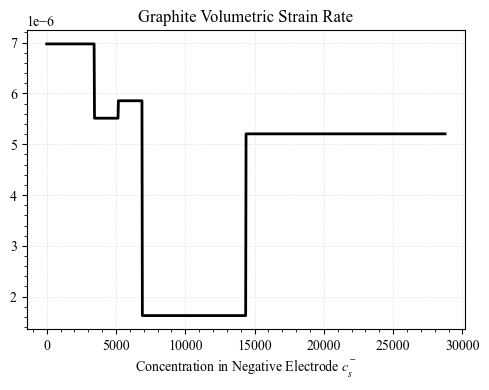

In [27]:
cs_max_n = 28746.0
sto = np.linspace(0,cs_max_n,1000)
yout = np.zeros(len(sto))
for i in range(len(sto)):
    yout[i] = graphite_volume_change_rate_mohtat(sto[i]/cs_max_n,cs_max_n)
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(sto,yout/cs_max_n,'k')
ax.set_xlabel(r'Concentration in Negative Electrode $c^-_{s}$')
# ax.set_ylabel(r'$\Delta\mathit{V}$')
ax.set_title("Graphite Volumetric Strain Rate")
fig.tight_layout()
plt.show()
plt.savefig(fig_DIR+'graphtite_vol_strain_rate'+'.png')

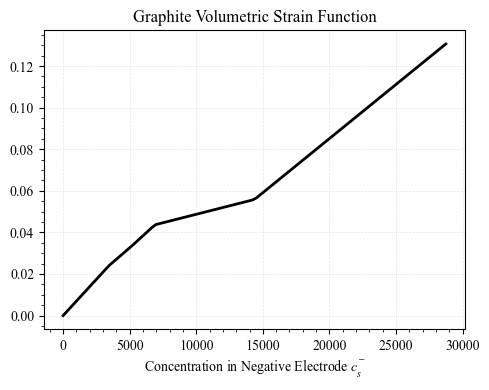

In [15]:
cs_max_n = 28746.0
sto = np.linspace(0,cs_max_n,100)
yout = np.zeros(len(sto))
for i in range(len(sto)):
    yout[i] = graphite_volume_change_mohtat(sto[i]/cs_max_n,29000).evaluate()
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(sto,yout,'k')
ax.set_xlabel(r'Concentration in Negative Electrode $c^-_{s}$')
# ax.set_ylabel(r'$\Delta\mathit{V}$')
ax.set_title("Graphite Volumetric Strain Function")
fig.tight_layout()
plt.show()
plt.savefig(fig_DIR+'graphtite_vol_strain'+'.png')

In [ ]:
dfgdfg

NameError: name 'dfgdfg' is not defined

In [ ]:
sto = np.linspace(0,1,100)
yout = np.zeros(len(sto))
yout1 = np.zeros(len(sto))
for i in range(len(sto)):
    yout[i] = graphite_volume_change(sto[i])
    yout1[i] = graphite_volume_change_mohtat(sto[i]).evaluate()
plt.figure()
plt.plot(sto,yout)
plt.plot(sto,yout1,'--')
plt.xlim([0,1])
plt.legend(['Matlab','PyBaMM Interpolant'])
plt.xlabel('Stoich')
plt.ylabel('Volumetric Strain')
plt.title('Graphite Vol Strain Function')
plt.savefig('exp_func')

In [ ]:
# fig, ax = plt.subplots(1, 2, figsize=(6, 4))
# ax1 = ax.flat[0]
# ax1.plot(t1,sigma_hs_p1,'b--')
# ax1.plot(t2,sigma_hs_p2,'r--')
# ax1.set_title(r'$\sigma^+_{h,surf}$ [Pa]')
# ax2 = ax.flat[1]
# ax2.plot(t1,C_p1[0]-C_p1,'b--')
# ax2.plot(t2,C_p2[0]-C_p2,'r--')
# ax2.set_title(r'$C_{p,loss}$ [Ah]')
# fig.tight_layout()
# plt.savefig(fig_DIR+'positive_electrode_stress'+'.png')

In [ ]:
# sigma_hs_p1_min = min(sigma_hs_p1/1e6)
# sigma_hs_p2_min = min(sigma_hs_p2/1e6)
# print(sigma_hs_p1_min)
# print(sigma_hs_p2_min)
# print(sigma_hs_p2_min/sigma_hs_p1_min)

In [ ]:
# parameter_values.search("max")

In [ ]:
# aSAs

In [ ]:
# fig, axes = plt.subplots(2, 3, figsize=(8, 6))
# ax1 = axes.flat[0]
# ax1.plot(t1,V1,'b')
# ax1.plot(t2,V2,'rv-')
# ax1.set_title('Voltage [V]')
# ax3 = axes.flat[3]
# ax3.plot(t1,phi_pl1,'b')
# ax3.plot(t2,phi_pl2,'rv-')
# ax3.set_ylim([-0.1,1])
# ax3.set_title('Plating Overpotential [V]')
# ax4 = axes.flat[5]
# ax4.plot(t1,phi_sei1,'b')
# ax4.plot(t2,phi_sei2,'rv-')
# # ax4.set_ylim([-0.1,1])
# ax4.set_title('SEI Overpotential [V]')
# ax2 = axes.flat[2]
# ax2.plot(t1,Q_Li1,'b')
# ax2.plot(t2,Q_Li2,'rv-')
# ax2.set_title('Capacity lost due to plating [Ah]')
# ax6=axes.flat[1]
# ax6.plot(t1,I_Li1,'b')
# ax6.plot(t2,I_Li2,'rv-')
# ax6.set_title('Lithium plating interfacial current density')
# ax5=axes.flat[4]
# ax5.plot(t1,phi_del1,'b')
# ax5.plot(t2,phi_del2,'rv-')
# ax5.set_ylim([-0.1,1])

# ax1.plot(t3,V3,'g--')
# ax3.plot(t3,phi_pl3,'g--')
# ax4.plot(t3,phi_sei3,'g--')
# ax2.plot(t3,Q_Li3,'g--')
# ax6.plot(t3,I_Li3,'g--')
# ax5.plot(t3,phi_del3,'g--')
# ax5.set_title('Neg Elec Surf Pot Diff [V]')
# # ax5.set_ylim([-0.1,1])
# # ax1.legend(['baseline',r'decreasing $\alpha_{pl}$',r'Increasing $k_{0,pl}$'])
# # ax1.legend(['Irreversible ','Reversible','Partially Reversible'])
# ax1.legend(['C/5','1.5C','New Params'])
# # ax1.legend(['SPM','SPMe'])
# fig.tight_layout()
# # plt.savefig(fig_DIR+'plating_models_parameters'+'.png')
# plt.savefig(fig_DIR+'plating_compare_crate'+'.png')
# # plt.savefig(fig_DIR+'plating_compare_spme'+'.png')

In [ ]:
# fig, axes = plt.subplots(3, 1, figsize=(6,8))
# ax1 = axes.flat[0]
# ax1.plot(Q1,phi_ocp1,'b')
# ax1.plot(Q2,phi_ocp2,'rv-')
# ax1.set_title('Negative Electrode Open Circuit Potential [V]')
# ax2 = axes.flat[1]
# ax2.plot(Q1,phi_int1,'b')
# ax2.plot(Q2,phi_int2,'rv-')
# ax2.set_title('Negative Electrode Intercalation Overpotential [V]')
# ax3 = axes.flat[2]
# ax3.plot(Q1,phi_pl1,'b')
# ax3.plot(Q2,phi_pl2,'rv-')
# ax3.set_title('Plating Overpotential [V]')
# # ax5.set_ylim([-0.1,1])
# # ax1.legend(['baseline',r'decreasing $\alpha_{pl}$',r'Increasing $k_{0,pl}$'])
# # ax1.legend(['Irreversible ','Reversible','Partially Reversible'])
# ax1.legend(['C/5','1.5C','High R'])
# # ax1.legend(['SPM','SPMe'])
# fig.tight_layout()
# # plt.savefig(fig_DIR+'plating_models_parameters'+'.png')
# # plt.savefig(fig_DIR+'plating_compare_crate'+'.png')
# # plt.savefig(fig_DIR+'plating_compare_spme'+'.png')

In [ ]:
# fig, axes = plt.subplots(1, 2, figsize=(9, 4))
# ax1 = axes.flat[0]
# ax1.plot(t1,sigma_hs_n1,'b--')
# ax1.plot(t2,sigma_hs_n2,'rv-')
# ax1.set_title(r'$\sigma_{h,surf}$ [Pa]')
# ax11 = axes.flat[1]
# ax11.plot(t1,c_ss_n1-c_save_n1,'b--')
# # ax11.plot(t1,c_save_n1,'b--')
# ax11.plot(t2,c_ss_n2-c_save_n2,'rv-')
# ax11.set_title(r'$c_{ss}^--c_{s,avg}^-$ [mol.$m^{-3}$]')
# plt.savefig(fig_DIR+'mech_stress_crate'+'.png')

In [ ]:
parameter_values.search("plating")

In [ ]:
# min(-np.exp(-alpha_pl*F/R/T*phi_pl2))/min(-np.exp(-alpha_pl*F/R/T*phi_pl1))

In [ ]:
(c_ss_n1-c_save_n1)/I1

In [ ]:
csmax_n = 28746
F = 96485
R = 8.314
T = 273.15+25
alpha_pl = 0.65
fig, ax = plt.subplots(2, 1, figsize=(5, 7))
ax1 = ax.flat[0]
ax1.plot(t1/t1[-1],(c_ss_n1-c_save_n1),'b--')
ax1.plot(t2/t2[-1],(c_ss_n2-c_save_n2),'rv-')
ax1.set_title(r'$(c_{ss}^--c_{s,avg}^-)/c_{s,max}^-$ [mol.$m^{-3}$]')
ax1.set_xlabel("Normalized Time")
ax1.legend(['C/5','1.5C'])
ax1 = ax.flat[1]
ax1.plot(t1/t1[-1],(c_ss_n1-c_save_n1)/I1,'b--')
ax1.plot(t2/t2[-1],(c_ss_n2-c_save_n2)/I2,'rv-')
ax1.set_title(r'$\frac{c_{ss}^--c_{s,avg}^-}{I}$')
fig.tight_layout()
plt.savefig(fig_DIR+'plating_css_vs_I'+'.png')

In [ ]:
csmax_n = 28746
F = 96485
R = 8.314
T = 273.15+25
alpha_pl = 0.65
fig, axes = plt.subplots(2, 2, figsize=(7, 5))
ax2 = axes.flat[1]
ax2.plot(t1/t1[-1],phi_pl1,'b')
ax2.plot(t2/t2[-1],phi_pl2,'rv-')
ax2.axhline(y = 0.0, color = 'k', linestyle = '--')
ax2.set_title(r'$\eta_{pl}$ [V]')
ax4 = axes.flat[3]
ax4.plot(t1/t1[-1],-np.exp(-alpha_pl*F/R/T*phi_pl1),'b')
ax4.plot(t2/t2[-1],-np.exp(-alpha_pl*F/R/T*phi_pl2),'rv-')
ax4.set_title(r'$exp\left(\frac{-\alpha_{c,pl}F}{RT}\eta_{pl}\right)$')
ax1 = axes.flat[0]
# ax1.plot(t1,c_save_n1*csmax_n,'b--')
# ax1.plot(t2,c_save_n2*csmax_n,'r--')
ax1.plot(t1/t1[-1],c_ss_n1*csmax_n,'b')
ax1.plot(t2/t2[-1],c_ss_n2*csmax_n,'rv-')
ax1.set_title(r'$c_{ss}^-$ [mol.$m^{-3}$]')
ax3 = axes.flat[2]
ax3.plot(t1/t1[-1],(c_ss_n1-c_save_n1)*csmax_n,'b--')
ax3.plot(t2/t2[-1],(c_ss_n2-c_save_n2)*csmax_n,'rv-')
ax3.set_title(r'$c_{ss}^--c_{s,avg}^-$ [mol.$m^{-3}$]')
# ax11.plot(t2,c_save_n2,'r--')
# ax11.legend(['surf','ave'])
ax3.set_xlabel("Normalized Time")
ax4.set_xlabel("Normalized Time")
# ax4.set_xlabel("Time [hr]")
ax2.legend(['C/5','1.5C'])
# axis = [ax1,ax2,ax5,ax3,ax9,ax7,ax4,ax8,ax6,ax10,ax11,ax12]
# labels = ["a)","b)","c)","d)","e)","f)","g)","h)","i)","j)","k)","l)"]
# for ax, label in zip(axis,labels):
#   ax.text(-0.1,1.1,label,transform=ax.transAxes, fontsize=14)  
fig.tight_layout()
plt.savefig(fig_DIR+'plating_compare_crate_1'+'.png')

In [ ]:

fig, axes = plt.subplots(2, 1, figsize=(4, 6))
ax1=axes.flat[0]
ax1.plot(t1,I_Li1,'b')
ax1.plot(t2,I_Li2,'rv-')
ax1.set_title(r'$j_{pl}$ [A.$m^{-2}$]')
ax2 = axes.flat[1]
ax2.plot(t1,Q_Li1,'b')
ax2.plot(t2,Q_Li2,'rv-')
ax2.set_title('Capacity lost due to plating [Ah]')

# ax11.set_xlabel("Time [hr]")
ax2.set_xlabel("Time [hr]")
# ax5.set_ylim([-0.1,1])
# ax1.legend(['baseline',r'decreasing $\alpha_{pl}$',r'Increasing $k_{0,pl}$'])
# ax1.legend(['Irreversible ','Reversible','Partially Reversible'])
ax1.legend(['C/5','1.5C'])
# ax1.legend(['SPM','SPMe'])
fig.tight_layout()
# plt.savefig(fig_DIR+'plating_models_parameters'+'.png')
# plt.savefig(fig_DIR+'plating_compare_models_1p5C'+'.png')
plt.savefig(fig_DIR+'plating_compare_crate_2_1'+'.png')

In [ ]:

fig, axes = plt.subplots(6, 2, figsize=(8, 10))
ax1 = axes.flat[0]
ax1.plot(t1,V1,'b')
ax1.plot(t2,V2,'rv-')
ax1.set_title('Voltage [V]')
ax2 = axes.flat[2]
ax2.plot(t1,phi_ocp1,'b')
ax2.plot(t2,phi_ocp2,'rv-')
ax2.set_title(r'U($c_{ss})$  [V]')
ax3 = axes.flat[6]
ax3.plot(t1,phi_pl1,'b')
ax3.plot(t2,phi_pl2,'rv-')
ax3.axhline(y = 0.0, color = 'k', linestyle = '--')
ax3.set_title(r'$\eta_{pl}$ [V]')
ax4=axes.flat[3]
ax4.plot(t1,i0_int1,'b')
ax4.plot(t2,i0_int2,'rv-')
ax4.set_title(r'$i_0$  [A.$m^{-2}$]')
ax5=axes.flat[4]
ax5.plot(t1,phi_int1,'b')
ax5.plot(t2,phi_int2,'rv-')
ax5.set_title(r'$\eta_{int}$ [V]')
ax6=axes.flat[7]
ax6.plot(t1,I_Li1,'b')
ax6.plot(t2,I_Li2,'rv-')
ax6.set_title(r'$j_{pl}$ [A.$m^{-2}$]')
ax7 = axes.flat[1]
ax7.plot(t1,I1,'b')
ax7.plot(t2,I2,'rv-')
ax7.set_title('Current [A]')
ax8=axes.flat[5]
ax8.plot(t1,I_to1,'b')
ax8.plot(t2,I_to2,'rv-')
ax8.set_title(r'$j_{int}$  [A.$m^{-2}$]')
ax9=axes.flat[8]
ax9.plot(t1,phi_e_avg1,'b')
ax9.plot(t2,phi_e_avg2,'rv-')
ax9.set_title(r'$\overline{\Phi}^-_{e}$ [V]')
ax10=axes.flat[9]
ax10.plot(t1,c_e_avg1,'b')
ax10.plot(t2,c_e_avg2,'rv-')
ax10.set_title(r'$\overline{c}^-_{e}$ [mol.$m^{-3}$]')

ax11 = axes.flat[10]
ax11.plot(t1,c_ss_n1-c_save_n1,'b--')
# ax11.plot(t1,c_save_n1,'b--')
ax11.plot(t2,c_ss_n2-c_save_n2,'rv-')
# ax11.plot(t2,c_save_n2,'r--')
# ax11.legend(['surf','ave'])
ax11.set_title(r'$c_{ss}^--c_{s,avg}^-$ [mol.$m^{-3}$]')
ax12 = axes.flat[11]
ax12.plot(t1,Q_Li1,'b')
ax12.plot(t2,Q_Li2,'rv-')
ax12.set_title('Capacity lost due to plating [Ah]')

ax11.set_xlabel("Time [hr]")
ax12.set_xlabel("Time [hr]")
# ax5.set_ylim([-0.1,1])
# ax1.legend(['baseline',r'decreasing $\alpha_{pl}$',r'Increasing $k_{0,pl}$'])
# ax1.legend(['Irreversible ','Reversible','Partially Reversible'])
# ax1.legend(['C/5','1.5C'])
ax1.legend(['1.5C','2C'])
axis = [ax1,ax2,ax5,ax3,ax9,ax7,ax4,ax8,ax6,ax10,ax11,ax12]
labels = ["a)","b)","c)","d)","e)","f)","g)","h)","i)","j)","k)","l)"]
for ax, label in zip(axis,labels):
  ax.text(-0.1,1.1,label,transform=ax.transAxes, fontsize=14)  

# ax1.legend(['SPM','SPMe'])
fig.tight_layout()
# plt.savefig(fig_DIR+'plating_models_parameters'+'.png')
# plt.savefig(fig_DIR+'plating_compare_models_1p5C'+'.png')
plt.savefig(fig_DIR+'plating_compare_crate_new_2'+'.png')

In [ ]:
i_pl_area1 = np.trapz(I_Li1,t1)
i_pl_avg1 = i_pl_area1/t1[-1]
i_pl_area2 = np.trapz(I_Li2,t2)
i_pl_avg2 = i_pl_area2/t2[-1]
print(i_pl_avg1)
print(i_pl_avg2)
print(i_pl_avg2/i_pl_avg1)
print(Q_Li2[-1]/Q_Li1[-1])

In [ ]:
fgdfgd

# Concentration Evolution

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(t1/t1[-1],c_ss_n1,'b')
ax.plot(t1/t1[-1],c_save_n1,'b--')
ax.plot(t1/t1[-1],c_s_n1[0,:],'b-.')
ax.plot(t2/t2[-1],c_ss_n2,'r')
ax.plot(t2/t2[-1],c_save_n2,'r--')
ax.plot(t2/t2[-1],c_s_n2[0,:],'r-.')
ax.legend([r"C/5 $c_{ss}$",r"C/5 $c_{s,ave}$",r"C/5 $c_{s,0}$",r"1.5C $c_{ss}$",r"1.5C $c_{s,ave}$",r"1.5C $c_{s,0}$"])
ax.set_xlabel("Normalized Time")
ax.set_ylabel("Conc [mol$m^{-3}$]")
ax.set_title(r'Negative Electrode Li Concentration $c_s$')
fig.savefig(fig_DIR+"neg_conc_crate_comp_norm"+".png")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(t1/t1[-1],c_ss_n1,'b')
ax.plot(t1/t1[-1],c_save_n1,'b--')
# ax.plot(t1/t1[-1],c_s_n1[0,:],'b-.')
ax.plot(t2/t2[-1],c_ss_n2,'r')
ax.plot(t2/t2[-1],c_save_n2,'r--')
# ax.plot(t2/t2[-1],c_s_n2[0,:],'r-.')
ax.legend([r"C/5 $c_{ss}$",r"C/5 $c_{s,ave}$",r"1.5C $c_{ss}$",r"1.5C $c_{s,ave}$"])
ax.set_xlabel("Normalized Time")
ax.set_ylabel(r"Normalized Concentration [$x=c_{s}/c_{s,max}$]")
ax.set_title(r'Negative Electrode Li Concentration $c_s$')
fig.savefig(fig_DIR+"neg_conc_crate_comp_norm"+".png")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(t1/t1[-1],c_ss_n1-c_save_n1,'b')
# ax.plot(t1/t1[-1],c_s_n1[0,:],'b-.')
ax.plot(t2/t2[-1],c_ss_n2-c_save_n2,'r')
# ax.plot(t2/t2[-1],c_s_n2[0,:],'r-.')
ax.legend([r"C/5 $c_{ss}-c_{s,ave}$",r"1.5C $c_{ss}-c_{s,ave}$"])
ax.set_xlabel("Normalized Time")
ax.set_ylabel(r"Normalized Concentration [$x=c_{s}/c_{s,max}$]")
ax.set_title(r'Negative Electrode Li Concentration $c_s$')
fig.savefig(fig_DIR+"neg_conc_diff_crate_comp_norm"+".png")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(t1/t1[-1],u_css_n1,'b')
ax.plot(t2/t2[-1],u_css_n2,'r')
ax.legend(["C/5","1.5C"])
ax.set_xlabel("Normalized Time")
ax.set_ylabel("Potential [V]")
ax.set_title(r'$U_n(c_{ss})$')
fig.savefig(fig_DIR+"neg_pot_crate_comp"+".png")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(t1/t1[-1],c_ss_n1-c_save_n1,'b')
# ax.plot(t1/t1[-1],c_save_n1-c_s_n1[0,:],'b--')
# ax.plot(t1/t1[-1],c_s_n1[0,:],'b-.')
ax.plot(t2/t2[-1],c_ss_n2-c_save_n2,'r')
# ax.plot(t2/t2[-1],c_save_n2-c_s_n2[0,:],'r--')
# ax.plot(t2/t2[-1],c_s_n2[0,:],'r-.')
ax.legend([r"C/5 $c_{ss}-c_{s,avg}$",r"1.5C $c_{ss}-c_{s,avg}$"])
ax.set_xlabel("Normalized Time")
ax.set_ylabel("Conc [mol$m^{-3}$]")
ax.set_title(r'Negative Electrode Li Concentration Difference $c_s$')

In [ ]:
len(t1)

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(5,3))
ax1.plot(t1,I1)
n=1
ax1.plot(t1[n],I1[n],'rx')
n=150
ax1.plot(t1[n],I1[n],'rx')
n=287
ax1.plot(t1[n],I1[n],'rx')
n=292
ax1.plot(t1[n],I1[n],'rx')
n=298
ax1.plot(t1[n],I1[n],'rx')

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(5,3))
ax1.plot(t2,I2)
n=1
ax1.plot(t2[n],I2[n],'rx')
n=18
ax1.plot(t2[n],I2[n],'rx')
n=36
ax1.plot(t2[n],I2[n],'rx')
n=46
ax1.plot(t2[n],I2[n],'rx')
n=56
ax1.plot(t2[n],I2[n],'rx')

In [ ]:
ln = np.linspace(0,1,20)
n = 1
print(t1[n]/60)
y1 = c_s_n1[:,n]
n = 10
y2 = c_s_n1[:,n]
n = 20
y3 = c_s_n1[:,n]
n = 30
y4 = c_s_n1[:,n]
n = 40
y5 = c_s_n1[:,n]
n = 50
y6 = c_s_n1[:,n]
fig, ax1 = plt.subplots(1, 1, figsize=(5,3))
ax1.plot(ln,y1)
ax1.plot(ln,y2,'--')
ax1.plot(ln,y3,'--')
ax1.plot(ln,y4,'--')
ax1.plot(ln,y5,'--')
ax1.plot(ln,y6,'--')
ax1.set_title(r'Negative Electrode $c_e-c_{e,ref}$ [mol.$m^{-3}$]')
ax1.set_xlabel("Negative electrode normalized length")
ax1.legend(["1 min","10 min","20 min","30 min","40 min","50 min"])
# ax1.legend(['C/5','1.5 C'])
fig.tight_layout()
# plt.savefig(fig_DIR+'dfn_c_e_5'+'.png')

In [ ]:
i_pl_area1 = np.trapz(I_Li1,t1)
i_pl_avg1 = i_pl_area1/t1[-1]
i_pl_area2 = np.trapz(I_Li2,t2)
i_pl_avg2 = i_pl_area2/t2[-1]
print(i_pl_avg1)
print(i_pl_avg2)
print(i_pl_avg2/i_pl_avg1)
print(Q_Li2[-1]/Q_Li1[-1])

In [ ]:
sadas

In [ ]:
out = parameter_values.evaluate(0.75*param.F/param.R/298.15)
print(out)

# Compare Lithium Plating average vs seperator overpotential

In [ ]:
t1_e,V1_e,I1_e,Q1_e,Q_Li1_e,I_Li1_e,I_de1_e,I_st1_e,I_to1_e,phi_seif1_e,phi_sei1_e,phi_pl1_e,phi_del1_e,phi_ocp1_e,phi_int1_e,i0_int1_e,phi_e_avg1_e,c_e_avg1_e,c_ss_n1_e,c_save_n1_e,c_s_n1_e,u_css_n1_e,j_pl1_e,eta_pl1_e = plot_vars(solution1_e)
t2_e,V2_e,I2_e,Q2_e,Q_Li2_e,I_Li2_e,I_de2_e,I_st2_e,I_to2_e,phi_seif2_e,phi_sei2_e,phi_pl2_e,phi_del2_e,phi_ocp2_e,phi_int2_e,i0_int2_e,phi_e_avg2_e,c_e_avg2_e,c_ss_n2_e,c_save_n2_e,c_s_n2_e,u_css_n2_e,j_pl2_e,eta_pl2_e = plot_vars(solution2_e)

In [ ]:
# ln = np.linspace(0,1,20)
# fig, ax1 = plt.subplots(1, 1, figsize=(5,3))
# # ax1.plot(t2_e,j_pl2_e[10,:])
# ax1.plot(ln,j_pl2_e[:,10])

In [ ]:
es_2 = solution2_e["X-averaged positive electrode active material volume fraction"].entries
R_n = parameter_values.evaluate(param.n.prim.R_typ)
F = parameter_values.evaluate(param.F)
j_pl2_max_e = j_pl2_e[-1,:]
nn = len(j_pl2_e)
j_pl2_a=0
eta_pl2_a=0
for i in range(nn):
    j_pl2_a+=j_pl2_e[i,:]
    eta_pl2_a+=eta_pl2_e[i,:]
j_pl2_av = j_pl2_a/nn
eta_pl2_av = eta_pl2_a/nn
d_c_lip_max = j_pl2_max_e
d_c_lip_av = j_pl2_av

eta_pl2_max_e = eta_pl2_e[-1,:]

as_2 = 3*es_2/R_n

mul =  parameter_values.evaluate(param.n.L*param.A_cc)
# mul =  parameter_values.evaluate(param.n.L)
mul2 = parameter_values.evaluate(param.n.L*param.L_y*param.L_z)
# mul2 = parameter_values.evaluate(param.L_z)

In [ ]:
Q_Li2_e_calc = -scipy.integrate.cumtrapz(d_c_lip_av*mul2*F,t2_e)
Q_Li2_e_calc = np.append(Q_Li2_e_calc,Q_Li2_e_calc[-1])

In [ ]:
Q_Li2_e_calc[-1] 

In [ ]:
Q_Li2_e[-1]

In [ ]:
fig, ax1= plt.subplots(1, 1, figsize=(5, 4))
ax1.plot(t2_e,Q_Li2_e)
ax1.plot(t2_e,Q_Li2_e_calc)

In [ ]:
c_lip_max = scipy.integrate.cumtrapz(d_c_lip_max,t2_e)
c_lip_max = np.append(c_lip_max,c_lip_max[-1])
c_lip_av = scipy.integrate.cumtrapz(d_c_lip_av,t2_e)
c_lip_av = np.append(c_lip_av,c_lip_av[-1])

In [ ]:
Q_Li2_e_max =c_lip_max/c_lip_av*Q_Li2_e

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
ax1 = axes.flat[0]
ax1.plot(t2_e,j_pl2_av)
ax1.plot(t2_e,j_pl2_max_e,'--')
ax1.set_title("Plating Current")
ax1.set_ylabel(r"Current [A$m^{-2}$]")
ax1.set_xlabel("Time [hr]")
ax1.legend(["Average","Maximum"])
ax2 = axes.flat[1]
ax2.plot(t2_e,Q_Li2_e)
ax2.plot(t2_e,Q_Li2_e_max,'--')
ax2.set_title(R"$Q_{loss,pl}$")
ax2.set_ylabel(r"Capacity Loss [Ah]")
ax2.set_xlabel("Time [hr]")
ax3 = axes.flat[2]
ax3.plot(t2_e,eta_pl2_av)
ax3.plot(t2_e,eta_pl2_max_e,'--')
ax3.set_title(R"$\eta_{pl}$")
ax3.set_ylabel(r"Overpotential [V]")
ax3.set_xlabel("Time [hr]")
fig.tight_layout()
plt.savefig(fig_DIR+'impact_eta_plmax'+'.png')

In [ ]:
t1,V1,I1,Q1,Q_Li1,I_Li1,I_de1,I_st1,I_to1,phi_seif1,phi_sei1,phi_pl1,phi_del1,phi_ocp1,phi_int1,i0_int1,phi_e_avg1,c_e_avg1,c_ss_n1,c_save_n1,c_s_n1 = plot_vars(solution1)
t2,V2,I2,Q2,Q_Li2,I_Li2,I_de2,I_st2,I_to2,phi_seif2,phi_sei2,phi_pl2,phi_del2,phi_ocp2,phi_int2,i0_int2,phi_e_avg2,c_e_avg2,c_ss_n2,c_save_n2,c_s_n2 = plot_vars(solution2)
fig, axes = plt.subplots(6, 2, figsize=(8, 10))
ax1 = axes.flat[0]
ax1.plot(t1,V1,'b')
ax1.plot(t2,V2,'rv-')
ax1.set_title('Voltage [V]')
ax2 = axes.flat[2]
ax2.plot(t1,phi_ocp1,'b')
ax2.plot(t2,phi_ocp2,'rv-')
ax2.set_title(r'U($c_{ss})$  [V]')
ax3 = axes.flat[6]
ax3.plot(t1,phi_pl1,'b')
ax3.plot(t2,phi_pl2,'rv-')
ax3.set_title(r'$\eta_{pl}$ [V]')
ax4=axes.flat[3]
ax4.plot(t1,i0_int1,'b')
ax4.plot(t2,i0_int2,'rv-')
ax4.set_title(r'$i_0$  [A.$m^{-2}$]')
ax5=axes.flat[4]
ax5.plot(t1,phi_int1,'b')
ax5.plot(t2,phi_int2,'rv-')
ax5.set_title(r'$\eta_{int}$ [V]')
ax6=axes.flat[7]
ax6.plot(t1,I_Li1,'b')
ax6.plot(t2,I_Li2,'rv-')
ax6.set_title(r'$j_{pl}$ [A.$m^{-2}$]')
ax7 = axes.flat[1]
ax7.plot(t1,I1,'b')
ax7.plot(t2,I2,'rv-')
ax7.set_title('Current [A]')
ax8=axes.flat[5]
ax8.plot(t1,I_to1,'b')
ax8.plot(t2,I_to2,'rv-')
ax8.set_title(r'$j_{int}$  [A.$m^{-2}$]')
ax9=axes.flat[8]
ax9.plot(t1,phi_e_avg1,'b')
ax9.plot(t2,phi_e_avg2,'rv-')
ax9.set_title(r'$\overline{\Phi}^-_{e}$ [V]')
ax10=axes.flat[9]
ax10.plot(t1,c_e_avg1,'b')
ax10.plot(t2,c_e_avg2,'rv-')
ax10.set_title(r'$\overline{c}^-_{e}$ [mol.$m^{-3}$]')

ax11 = axes.flat[10]
ax11.plot(t1,c_ss_n1-c_save_n1,'b--')
# ax11.plot(t1,c_save_n1,'b--')
ax11.plot(t2,c_ss_n2-c_save_n2,'r')
# ax11.plot(t2,c_save_n2,'r--')
ax11.legend(['surf','ave'])
ax11.set_title(r'$c_s^-$ [mol.$m^{-3}$]')
ax12 = axes.flat[11]
ax12.plot(t1,Q_Li1,'b')
ax12.plot(t2,Q_Li2,'rv-')
ax12.set_title('Capacity lost due to plating [Ah]')

ax11.set_xlabel("Time [hr]")
ax12.set_xlabel("Time [hr]")
# ax5.set_ylim([-0.1,1])
# ax1.legend(['baseline',r'decreasing $\alpha_{pl}$',r'Increasing $k_{0,pl}$'])
# ax1.legend(['Irreversible ','Reversible','Partially Reversible'])
ax1.legend(['1.5C','2C'])
axis = [ax1,ax2,ax5,ax3,ax9,ax7,ax4,ax8,ax6,ax10,ax11,ax12]
labels = ["a)","b)","c)","d)","e)","f)","g)","h)","i)","j)","k)","l)"]
for ax, label in zip(axis,labels):
  ax.text(-0.1,1.1,label,transform=ax.transAxes, fontsize=14)  

# ax1.legend(['SPM','SPMe'])
fig.tight_layout()
# plt.savefig(fig_DIR+'plating_models_parameters'+'.png')
# plt.savefig(fig_DIR+'plating_compare_models_1p5C'+'.png')
plt.savefig(fig_DIR+'plating_compare_crate_high_irrev'+'.png')

In [ ]:
asdasd

In [ ]:
c_ss_n1

In [ ]:
c_smax_n = 28746
f1 = (c_ss_p1**0.5)*((c_smax_n-c_ss_p1)**0.5)

fig, ax1 = plt.subplots(1, 1, figsize=(5, 4))
ax1.plot(t1,f1,'b')
# ax1.plot(t2,V2,'rv-')
ax1.set_title(r'$(c_{s,max}-c_{ss})^{1-\alpha}\times(c_{ss})^{\alpha}$')
ax1.set_xlabel("Time [hr]")
plt.savefig(fig_DIR+'exch_current_nonlinearity'+'.png')

In [ ]:
c_ss_p1 = np.linspace(1,0,51)

In [ ]:
c_smax_p =1
f1 = (c_ss_p1**0.05)*((c_smax_p-c_ss_p1)**0.05)

fig, ax1 = plt.subplots(1, 1, figsize=(5, 4))
ax1.plot(c_ss_p1,f1,'b')
# ax1.plot(t2,V2,'rv-')
ax1.set_title(r'$(c_{s,max}-c_{ss})^{1-\alpha}\times(c_{ss})^{\alpha}$')
# plt.savefig(fig_DIR+'exch_current_nonlinearity'+'.png')